In [11]:
# HOW CAN A CONVOLUTIONAL NEURAL NETWORK BE USED TO PERFORM SENTIMENT ANALYSIS ?

In [68]:
#___________________________READ DATA___________________________
import gzip
import json
import numpy as np
import pandas as pd
import re 

DIR = '/Users/bratislavpetkovic/Desktop/WGU/Advanced_Data_Analytics/Task_2/Books.json.gz'
def load_data(file_name, head = 500):
    count = 0
    data = []
    with gzip.open(file_name) as fin:
        for l in fin:
            d = json.loads(l)
            count += 1
            data.append(d)
            
            # break if reaches the 100th line
            if (head is not None) and (count > head):
                break
    return data

reviews_full_df = pd.DataFrame(load_data(DIR, head = 600000)).dropna(subset=['reviewText', 'overall'])[['overall', 'reviewText']]
#filter any review larger than 2500 characters 
reviews_full_df = reviews_full_df.loc[reviews_full_df['reviewText'].str.len() <= 2500]
print(reviews_full_df.shape)
negative_reviews_df = reviews_full_df[reviews_full_df['overall'] < 3][:40000]
positive_reviews_df = reviews_full_df[reviews_full_df['overall'] > 3][:40000]
reviews_df = pd.concat([positive_reviews_df, negative_reviews_df])  
print(negative_reviews_df.shape)
print(positive_reviews_df.shape)
print(reviews_df.shape)
print(reviews_df.overall.value_counts())

(583686, 2)
(40000, 2)
(40000, 2)
(80000, 2)
5.0    32089
1.0    20696
2.0    19304
4.0     7911
Name: overall, dtype: int64


In [74]:
#___________________________INSTALLATIONS___________________________
# !pip uninstall -y spacy
# !pip install -U spacy
# !pip install -U pydantic==1.8.0         # sneaky
# !pip install -U pip setuptools wheel
# !pip install nltk
# !pip install tensorflow
# !pip install wordcloud
# !python -m spacy download en_core_web_sm
# import nltk 
# nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 1.2 MB/s eta 0:00:00a 0:00:01


In [70]:
#___________________________STRUCTURING DATA___________________________
import nltk
import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser’" "ner"])
stopwords = nltk.corpus.stopwords.words("english")
stopwords_lower = [s.lower() for s in stopwords]

def text_preprocessing(str_input): 
     words = [token.lemma_ for token in nlp(str_input) if not token.is_punct]
     words = [re.sub(r"[^A-Za-z]", "", word) for word in words] 
     words = [re.sub(r"\S+com", "", word) for word in words]
     words = [re.sub(r"\S+@\S+", "", word) for word in words] 
     words = [word for word in words if word!=" "]
     words = [word for word in words if len(word)!=0] 
     words = [word.lower() for word in words ] 
     words=[word for word in words if word not in stopwords_lower]
     string = " ".join(words)
     # print(string)
     return string

text_reviews = []
count = 0
for review in reviews_df['reviewText']:
    if(count % 1000 == 0):
        print(count)
    text_reviews.append(text_preprocessing(review))
    count += 1
    
vocabulary = list(set(' '.join(text_reviews).split(' ')))



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000


There are 32573802 words in the combination of all review.


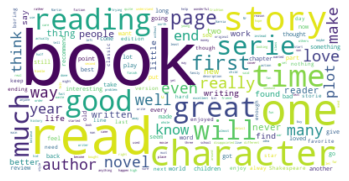

['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']
15.0


In [93]:
from wordcloud import WordCloud

text = " ".join(review for review in reviews_df['reviewText'])
print ("There are {} words in the combination of all review.".format(len(text)))
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

all_chars = []
for review in reviews_df['reviewText']:
    for char in review:
        if char not in all_chars:
            all_chars.append(char)
all_chars.sort()
print(all_chars) 

embedding_lenght = round(np.sqrt(np.sqrt(vocab_size)), 0)
print(embedding_lenght)

In [86]:
#___________________________TOKENIZATION___________________________
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_reviews)
reviews_tokens = tokenizer.texts_to_sequences(text_reviews)
reviews_words_count = [len(sentence) for sentence in reviews_tokens]
# print(sns.histplot(reviews_words_count))
reviews_tokens = pad_sequences(reviews_tokens, padding = 'pre' )

vocab_size = len(vocabulary)
print("Size of Corpus", vocab_size)
max_len_review = max([len(sentence) for sentence in reviews_tokens])

# BAD sentiment  : score < 3
# GOOD sentiment : score > 3 
sentiment_label = np.array([0 if x <= 3 else 1 for x in reviews_df['overall']])
X_train, X_test, y_train, y_test = train_test_split(reviews_tokens, sentiment_label, test_size=0.25, random_state=42)

train_df = pd.DataFrame(X_train)
train_df['Sentiment'] = y_train
train_df.to_csv('train_df.csv')
print(train_df.shape)
      
test_df = pd.DataFrame(X_test)
test_df['Sentiment'] = y_test
test_df.to_csv('test_df.csv')
print(test_df.shape)


Size of Corpus 55808
(60000, 251)
(20000, 251)


In [ ]:
#___________________________EXPLORATORY ANALYSIS___________________________
import seaborn as sns
import matplotlib.pyplot as plt

reviews_words_count = [len(sentence) for sentence in text_reviews]
print(sns.histplot(reviews_words_count))

flat_list = list(itertools.chain(*list2d))
# most common words, not stop words


In [87]:
# PADDED SEQUENCE EXMAMPLE
print(text_reviews[0])
print(reviews_tokens[0])

book winner boy really enjoy picture story classic
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0 

In [102]:
#___________________________CNN MODEL___________________________ 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Conv1D, MaxPooling1D 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras import Model

model_cnn = Sequential() 
model_cnn.add(Embedding(input_dim = vocab_size, output_dim = 32, input_length = max_len_review, trainable = True))
model_cnn.add(Conv1D(filters=16, kernel_size=3, padding='same', activation='relu')) 
model_cnn.add(MaxPooling1D(pool_size=2)) 
model_cnn.add(LSTM(32)) 
model_cnn.add(Dropout(rate=0.25)) 
model_cnn.add(Dense(1, activation='sigmoid')) 
model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_cnn.summary())

filepath="cnn_model_weights.hdf5" 
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True, save_weights_only=True) 
early_stop = EarlyStopping(patience=2, start_from_epoch=5, mode='max', min_delta= 0.025)

callbacks_list = [checkpoint, early_stop]
history = model_cnn.fit(X_train, y_train, epochs=14, batch_size=2500, verbose = 1, shuffle=True, 
                        callbacks = callbacks_list, validation_data=(X_test,y_test))

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_37 (Embedding)    (None, 250, 32)           1785856   
                                                                 
 conv1d_35 (Conv1D)          (None, 250, 16)           1552      
                                                                 
 max_pooling1d_34 (MaxPoolin  (None, 125, 16)          0         
 g1D)                                                            
                                                                 
 lstm_39 (LSTM)              (None, 32)                6272      
                                                                 
 dropout_37 (Dropout)        (None, 32)                0         
                                                                 
 dense_39 (Dense)            (None, 1)                 33        
                                                     

2500/2500 [==============================] - 17s 7ms/step
VALIDATION DATA REPORT : 
               precision    recall  f1-score   support

    Positive       0.92      0.89      0.91      9985
    Negative       0.90      0.92      0.91     10015

    accuracy                           0.91     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.91      0.91      0.91     20000

FULL DATASET REPORT    : 
               precision    recall  f1-score   support

    Positive       0.96      0.93      0.95     40000
    Negative       0.93      0.96      0.95     40000

    accuracy                           0.95     80000
   macro avg       0.95      0.95      0.95     80000
weighted avg       0.95      0.95      0.95     80000



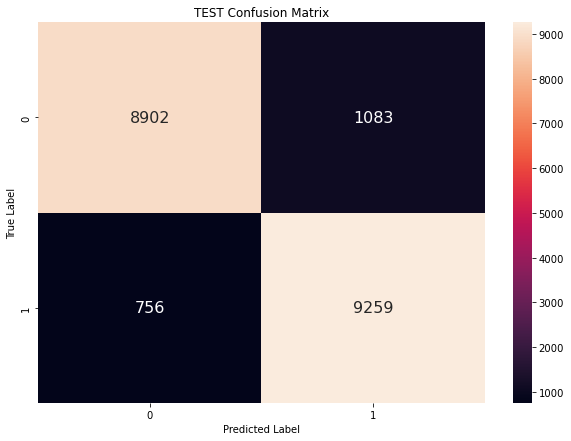

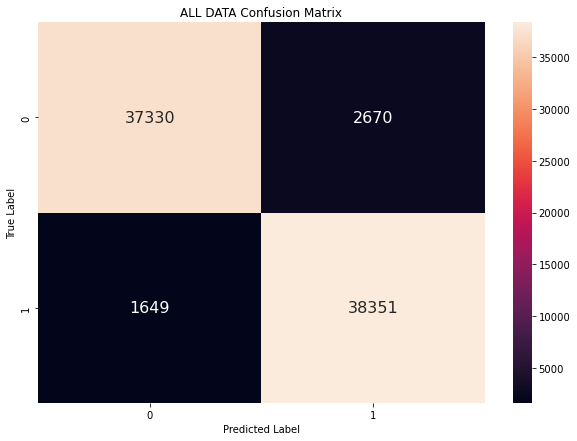

In [106]:
#___________________________EVALUATING MODEL ACCURACY___________________

y_pred_test = model_cnn.predict(X_test)
y_pred_test = [0 if x < 0.5 else 1 for x in y_pred_test]
test_report = c(y_test, y_pred_test, target_names=["Positive", "Negative"])

y_pred_full = model_cnn.predict(reviews_tokens)
y_pred_full = [0 if x < 0.5 else 1 for x in y_pred_full]
full_data_report = classification_report(sentiment_label, y_pred_full, target_names=["Positive", "Negative"])
                                     
print("VALIDATION DATA REPORT : \n", test_report)
print("FULL DATASET REPORT    : \n", full_data_report)

conf_mat_first = pd.DataFrame(confusion_matrix(y_test, y_pred_test))  
conf_mat_model = pd.DataFrame(confusion_matrix(sentiment_label, y_pred_full ))  

fig = plt.figure(figsize=(10, 7))  
sns.heatmap(conf_mat_first, annot=True, annot_kws={"size": 16}, fmt="g")  
plt.title("TEST Confusion Matrix")  
plt.xlabel("Predicted Label")  
plt.ylabel("True Label")  
plt.show()  

fig = plt.figure(figsize=(10, 7))  
sns.heatmap(conf_mat_model, annot=True, annot_kws={"size": 16}, fmt="g")  
plt.title("ALL DATA Confusion Matrix")  
plt.xlabel("Predicted Label")  
plt.ylabel("True Label")  
plt.show()



TESTING  Loss: 0.2531856894493103  Accuracy: 0.908050000667572
TRAINING Loss: 0.1298687756061554  Accuracy: 0.9586666822433472


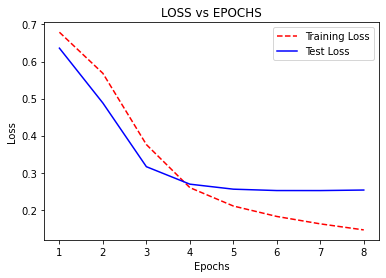

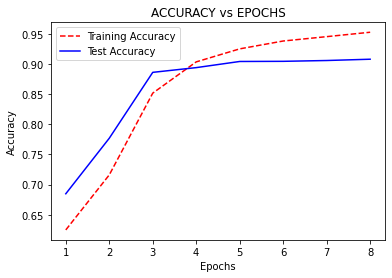

In [108]:
#___________________________EVALUATING LOSS and ACCURACY___________________

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("TESTING  Loss: {0}  Accuracy: {1}".format(*model_cnn.evaluate(X_test, y_test, verbose=0)))
print("TRAINING Loss: {0}  Accuracy: {1}".format(*model_cnn.evaluate(X_train, y_train, verbose=0)))

training_loss = history.history['loss']
test_loss = history.history['val_loss']

training_acc = history.history['accuracy']
test_acc = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LOSS vs EPOCHS')
plt.show();

# Visualize accuracy history
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('ACCURACY vs EPOCHS')
plt.show();

In [10]:
#___________________________RNN Model___________________________
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim = vocab_size, output_dim = 64, input_length = max_len_review, trainable = True))
model_rnn.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.15, activation='relu'))
model_rnn.add(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.15, activation='relu'))
model_rnn.add(Dense(16))
model_rnn.add(Dropout(rate=0.25))
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# NETWORK ARCHITECTURE 
print(model_rnn.summary())

filepath="rnn_model_rnn_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_best_only=True, save_weights_only=True)
callbacks_list = [checkpoint, early_stop]

model_rnn.fit(X_train, y_train, epochs=10, batch_size=2500, verbose = 1,
          callbacks = callbacks_list, validation_data=(X_test,y_test)) 

print("Loss: {0}\nAccuracy: {1}".format(*model_rnn.evaluate(X_test, y_test, verbose=0)))


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 250, 64)           3571712   
                                                                 
 lstm_4 (LSTM)               (None, 250, 64)           33024     
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,638,817
Trainable params: 3,638,817
No